In [1]:
import os
import numpy as np
import pandas as pd
from astropy.table import Table

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp

from lvmdrp.functions import imageMethod, rssMethod

ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}

In [2]:
frames_table = md.get_metadata(tileid="*", mjd=60177)
frames_table.query("imagetyp == 'bias' | imagetyp == 'dark' | imagetyp == 'flat' | imagetyp == 'arc'", inplace=True)

[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5
[INFO]: found 567 frames in store '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5'
[INFO]: number of frames after filtering 567
[INFO]: total number of frames found 567


In [3]:
masters_mjd = frames_table.mjd.min()
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")

In [4]:
masters_flat = md.get_metadata(kind="master", imagetyp="flat").query("mjd == @masters_mjd").sort_values("camera")
masters_flat

[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: found 45 frames in store '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5'
[INFO]: filtering by imagetyp = 'flat'
[INFO]: number of frames after filtering 18
[INFO]: total number of frames found 18


,tileid,mjd,rmjd,imagetyp,spec,camera,exptime,neon,hgne,krypton,...,argon,ldls,quartz,quality,qual,stage,status,drpqual,nframes,name
12,1111,60177,60177,flat,sp1,b1,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-b1
14,1111,60177,60177,flat,sp2,b2,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-b2
10,1111,60177,60177,flat,sp3,b3,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-b3
16,1111,60177,60177,flat,sp1,r1,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-r1
11,1111,60177,60177,flat,sp2,r2,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-r2
15,1111,60177,60177,flat,sp3,r3,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,2,lvm-mflat_ldls-r3
13,1111,60177,60177,flat,sp1,z1,10.0,False,False,False,...,False,False,True,excellent,0,1,0,0,2,lvm-mflat_quartz-z1
9,1111,60177,60177,flat,sp2,z2,10.0,False,False,False,...,False,False,True,excellent,0,1,0,0,2,lvm-mflat_quartz-z2
17,1111,60177,60177,flat,sp3,z3,10.0,False,False,False,...,False,False,True,excellent,0,1,0,0,2,lvm-mflat_quartz-z3


In [5]:
mtrace_paths = []
for flat in masters_flat.to_dict("records"):
    camera = flat["camera"]
    # define lamps for flats and arcs
    con_lamp = MASTER_CON_LAMPS[camera[0]]
    arc_lamp = MASTER_ARC_LAMPS[camera[0]]
    
    # define masters paths
    mflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=masters_mjd, kind=f"mflat_{con_lamp}", camera=camera)
    mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
    mwave_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
    mlsf_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
    # define master fiberflat path
    wflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=masters_mjd, kind=f"wmflat_{con_lamp}", camera=camera)

    imageMethod.extract_spectra(in_image=mflat_path, out_rss=wflat_path, in_trace=mtrace_path, method="aperture", aperture=3)
    rssMethod.create_pixel_table(in_rss=wflat_path, out_rss=wflat_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)

[INFO]: reading continuum exposure from lvm-wmflat_ldls-b1.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-b2.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-b3.fits
[INFO]: caculating normalization in full wavelength range (3504.81 - 5990.90 angstroms)
[INFO]: computing fiberflat across 1944 fibers and 4080 wavelength bins
[INFO]: applying gaussian smoothing with kernel size 2.5 angstroms (4 pixels)
[WARNING]: at fiber 1: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 109: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 217: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 289: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 325: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 397: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 414: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber

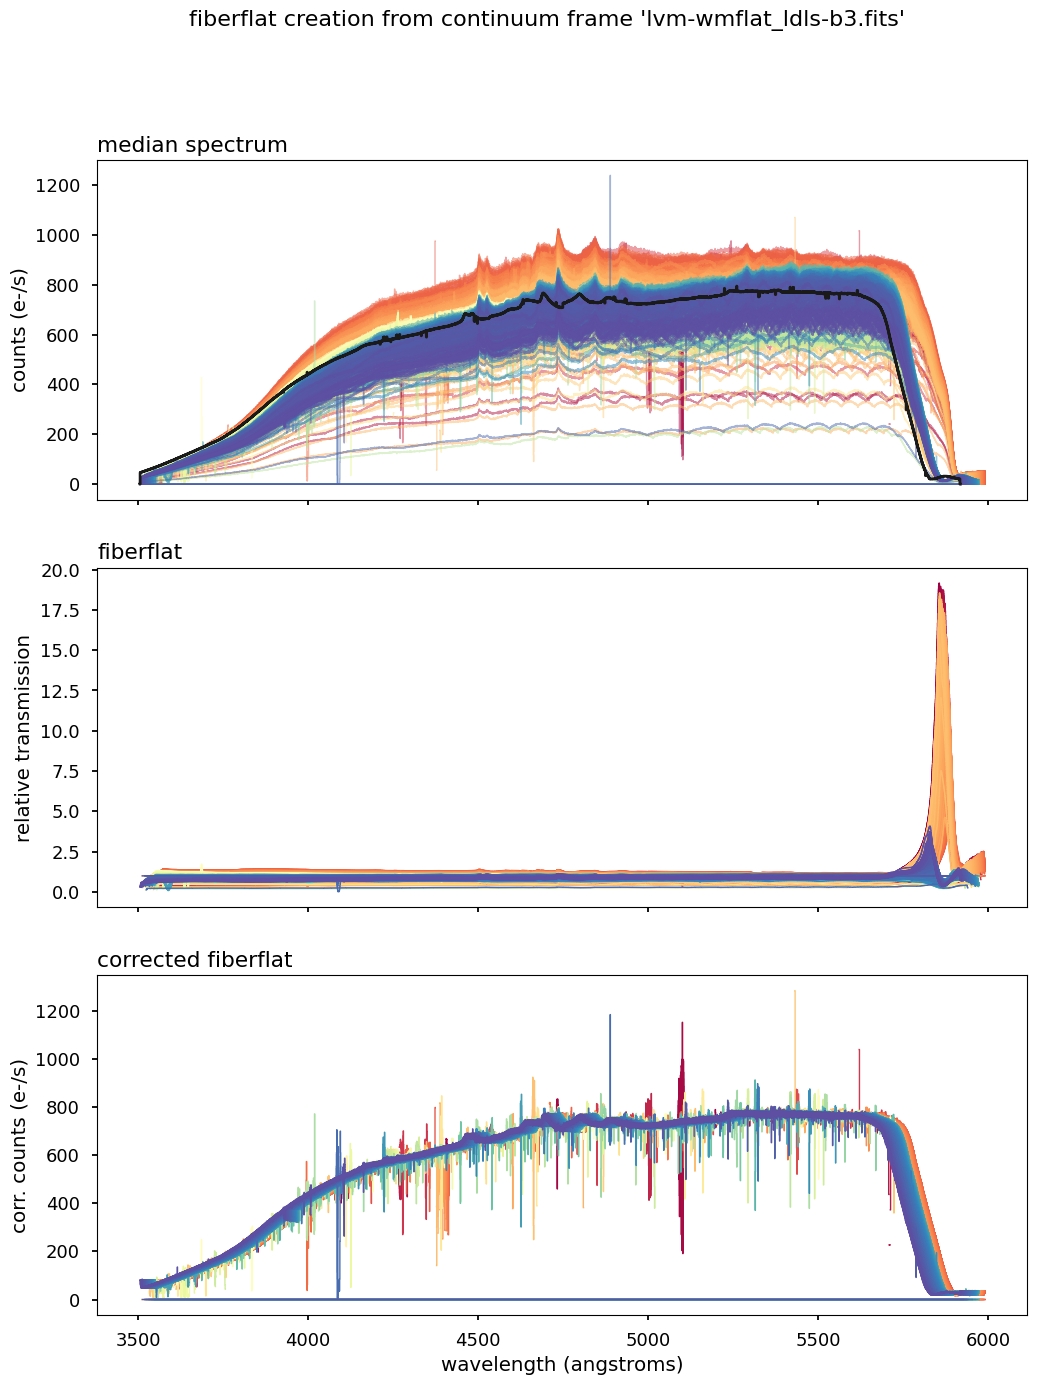

[INFO]: writing fiberflat to lvm-mfiberflat-b1.fits
[INFO]: fiberflat statistics: min = 0.153, max = 19.168, mean = 1.27, median = 1.12, std = 0.995
[INFO]: writing fiberflat to lvm-mfiberflat-b2.fits
[INFO]: fiberflat statistics: min = 0.118, max = 3.090, mean = 0.91, median = 0.91, std = 0.133
[INFO]: writing fiberflat to lvm-mfiberflat-b3.fits
[INFO]: fiberflat statistics: min = 0.007, max = 4.084, mean = 0.96, median = 0.98, std = 0.128
[INFO]: reading continuum exposure from lvm-wmflat_ldls-r1.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-r2.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-r3.fits
[INFO]: caculating normalization in full wavelength range (5560.01 - 7790.14 angstroms)
[INFO]: computing fiberflat across 1944 fibers and 4080 wavelength bins
[INFO]: applying gaussian smoothing with kernel size 2.5 angstroms (4 pixels)
[WARNING]: at fiber 1: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 109: cannot reshape array of

<Figure size 1040x715 with 0 Axes>

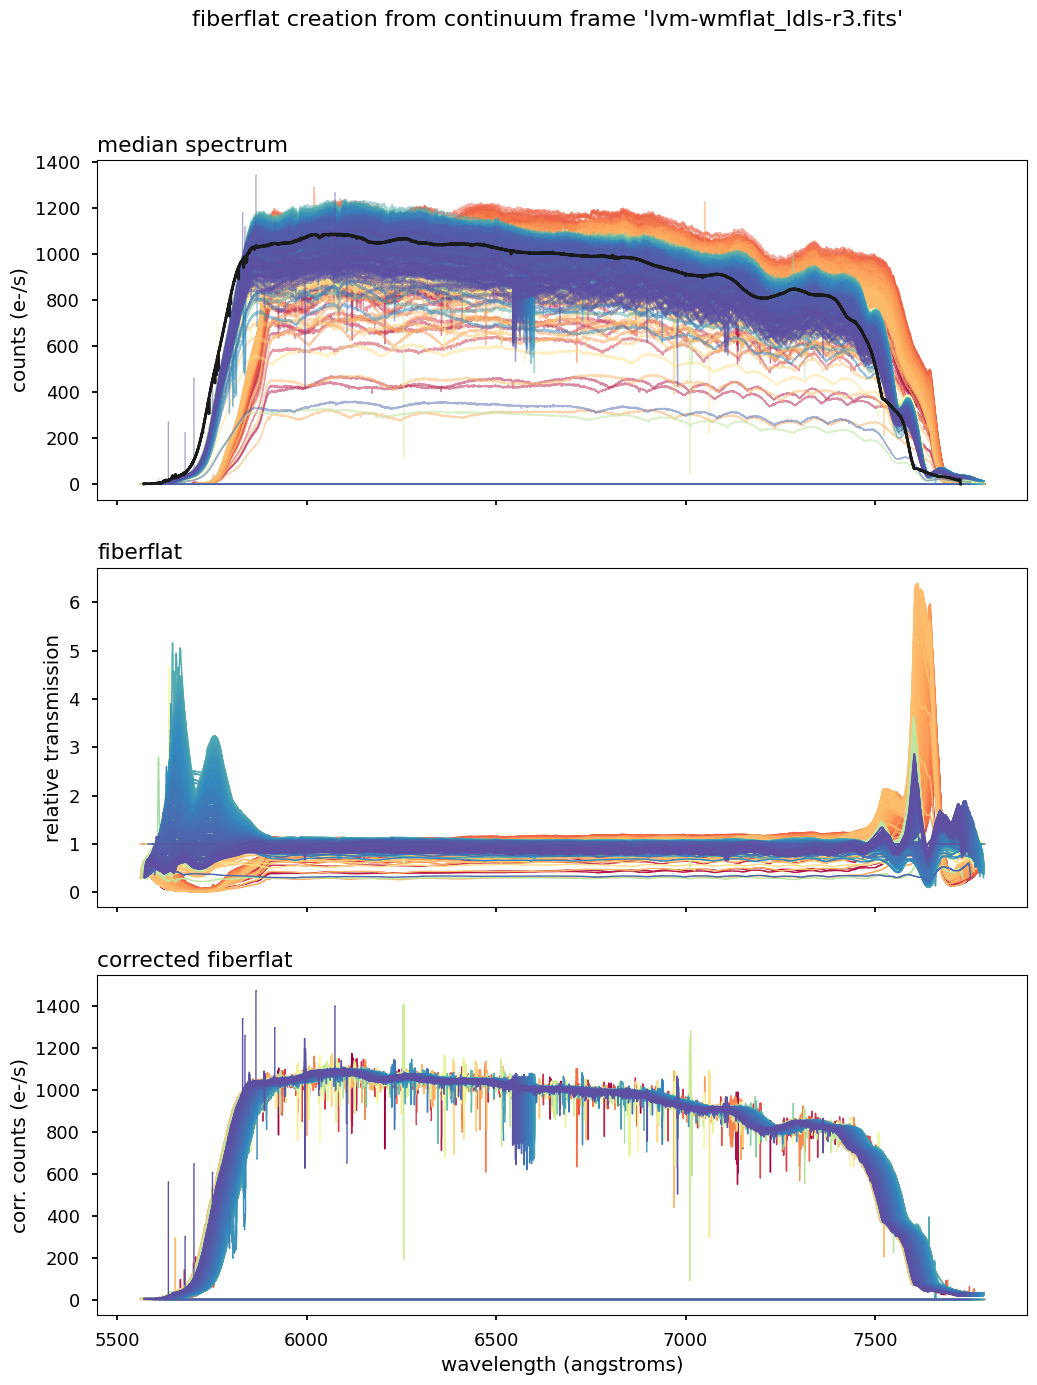

[INFO]: writing fiberflat to lvm-mfiberflat-r1.fits
[INFO]: fiberflat statistics: min = 0.011, max = 6.401, mean = 0.99, median = 1.01, std = 0.522
[INFO]: writing fiberflat to lvm-mfiberflat-r2.fits
[INFO]: fiberflat statistics: min = 0.126, max = 4.660, mean = 1.01, median = 0.98, std = 0.236
[INFO]: writing fiberflat to lvm-mfiberflat-r3.fits
[INFO]: fiberflat statistics: min = 0.099, max = 5.160, mean = 1.06, median = 1.01, std = 0.345
[INFO]: reading continuum exposure from lvm-wmflat_quartz-z1.fits
[INFO]: reading continuum exposure from lvm-wmflat_quartz-z2.fits
[INFO]: reading continuum exposure from lvm-wmflat_quartz-z3.fits
[INFO]: caculating normalization in full wavelength range (7343.97 - 9889.75 angstroms)
[INFO]: computing fiberflat across 1944 fibers and 4080 wavelength bins
[INFO]: applying gaussian smoothing with kernel size 2.5 angstroms (4 pixels)
[WARNING]: at fiber 1: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 109: cannot reshape arr

<Figure size 1040x715 with 0 Axes>

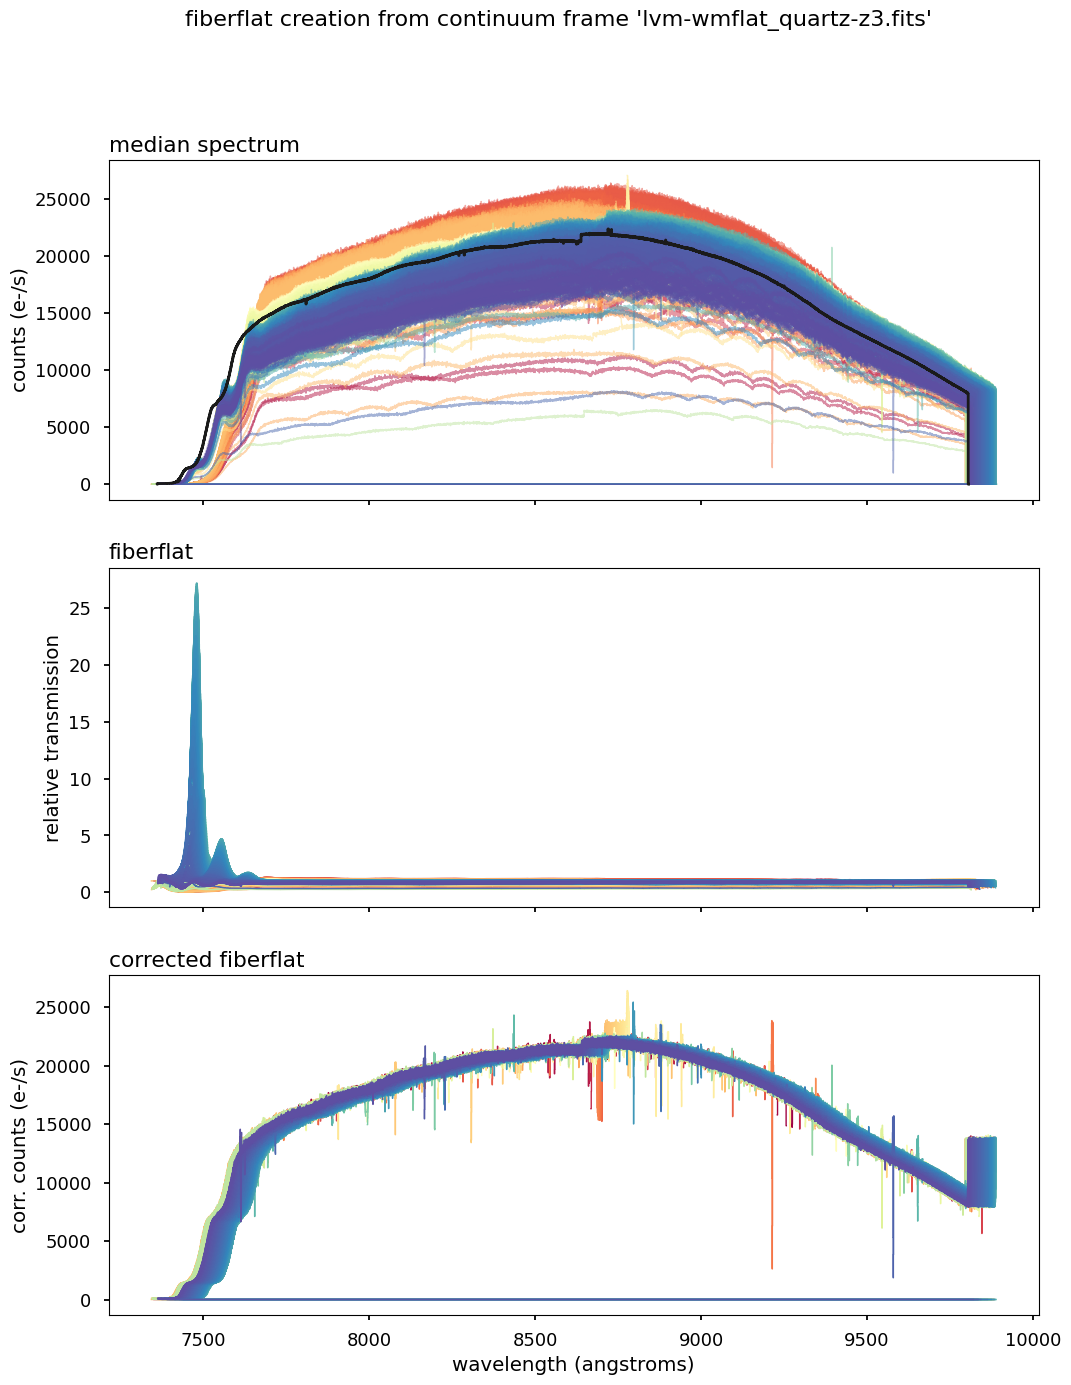

[INFO]: writing fiberflat to lvm-mfiberflat-z1.fits
[INFO]: fiberflat statistics: min = 0.035, max = 1.313, mean = 1.00, median = 1.04, std = 0.183
[INFO]: writing fiberflat to lvm-mfiberflat-z2.fits
[INFO]: fiberflat statistics: min = 0.054, max = 7.957, mean = 1.03, median = 0.99, std = 0.337
[INFO]: writing fiberflat to lvm-mfiberflat-z3.fits
[INFO]: fiberflat statistics: min = 0.203, max = 27.224, mean = 1.15, median = 0.99, std = 1.371
[INFO]: going to extract metadata from 3 frames
extracting metadata: 100%|#################################################################################| 3/3 [00:00<00:00, 384.76frame/s]
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60177/raw_metadata.hdf5
[INFO]: updating metadata store for tileid = 1111 and mjd = 60177 with 3 new rows
[INFO]: final number of rows 570
[INFO]: writing raw metadata store to disk
[INFO]: loading metadata

<Figure size 1040x715 with 0 Axes>

In [6]:
for channel in "brz":
    wflat_paths, mfiberflat_paths = [], []
    for flat in masters_flat.to_dict("records"):
        camera = flat["camera"]
        if camera[0] != channel: continue
        con_lamp = MASTER_CON_LAMPS[camera[0]]
        wflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=masters_mjd, kind=f"wmflat_{con_lamp}", camera=camera)
        mfiberflat_path = os.path.join(masters_path, f"lvm-mfiberflat-{camera}.fits")
        mfiberflat_paths.append(mfiberflat_path)
        wflat_paths.append(wflat_path)

    rssMethod.create_fiberflat(in_rsss=wflat_paths, out_rsss=mfiberflat_paths, median_box=0, gaussian_kernel=2.5, display_plots=True)

# cache new masters metadata into HDF5 files
new_masters = md.extract_metadata(frames_paths=mfiberflat_paths)
md.add_masters(new_masters)